<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/S9_Master_Model_ResNet_Gradcam_Albumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
%cd gdrive/My Drive/project_folder
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/S9_Resnet_Gradcam_Albumentations
! ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/project_folder
Cloning into 'Deep_Learning_EVA4_Phase1'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 952 (delta 81), reused 0 (delta 0), pack-reused 808
Receiving objects: 100% (952/952), 8.76 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (589/589), done.
/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/S9_Resnet_Gradcam_Albumentations
models	README.md  S9_GradCam_Images.zip


In [0]:
#!pip install torchviz

In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
#from torchviz import make_dot
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from models import Alb_data_transforms,Model,Dataloaders,Train_Losses,Test_losses,Gradcam

Below section of code is to get the mean and stdev of train data which will be used for normalization while applying transforms. **No need to execute this everytime** we run the file

In [0]:
train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

n = 0
s = np.zeros(3)
sq = np.zeros(3)
i = 0
batchsize = 128
for data, l in tqdm_notebook(train):
  x = np.array(data)/255                             # Image Normalization 
  s += x.sum(axis=(0,1))                             # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))             # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n += x.shape[0]*x.shape[1]                         # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print('No: Of Train Images:', i, '\n'
      'No: Of Batches:', batches, '\n'
      'Channels Mean:',mu, '\n'
      'Channels Stdev:',std, '\n'
      'Channels squared sum mean:', sq/n, '\n'
      'Total Pixles (N):', n)

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



No: Of Train Images: 50000 
No: Of Batches: 390 
Channels Mean: [0.49139968 0.48215841 0.44653091] 
Channels Stdev: [0.24703223 0.24348513 0.26158784] 
Channels squared sum mean: [0.30249857 0.29176174 0.26781806] 
Total Pixles (N): 51200000


In [3]:
# 0.4.5 is the latest albumentation version
!pip install albumentations==0.4.5

In [4]:
import albumentations as A

data_loader = Dataloaders.DataLoader(shuffle=True,batch_size=128,seed=1)

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
fillmeans = (np.array(channels_mean)*255).astype(np.uint8) # This is to fill additional space coming up while rotating image
              
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=channels_mean, std=channels_stdev),
                                                                  A.Cutout(num_holes=1,max_h_size=8,max_w_size=8) 
                                                                  # fillvalue for cutout= default i.e. 0 as after normalizing mean is 0
                                                                  # size as 8 i.e. 25% of 32x32 CIFAR 10 data
                                                                  
                                                                 ])

train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Below section of code is to display train images from training set



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

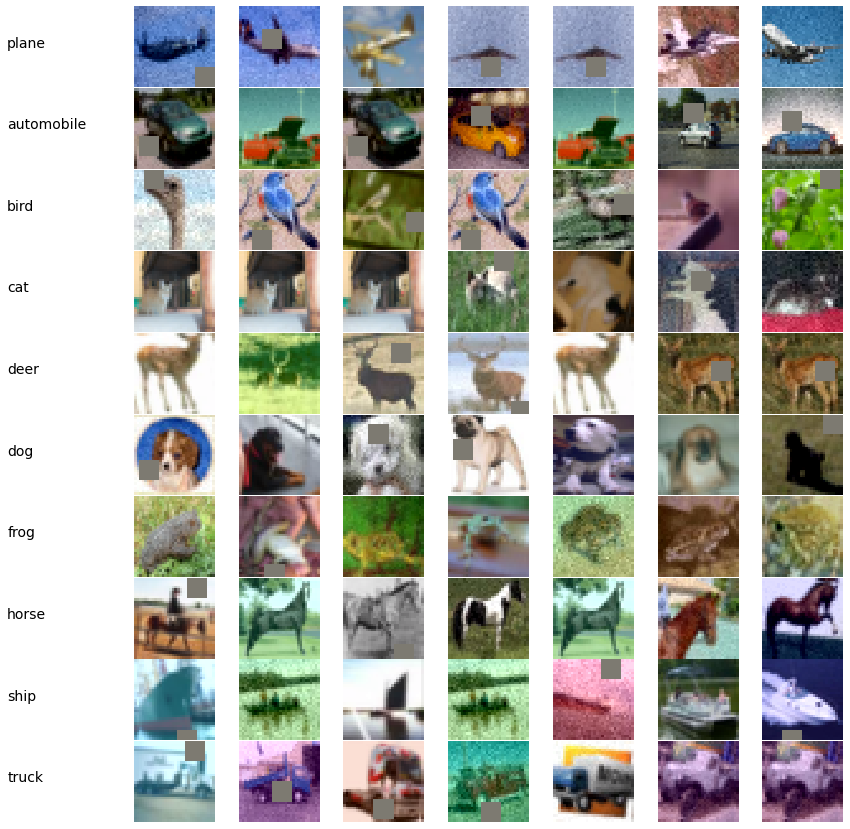

In [5]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)

# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display

def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
  
  return np.transpose(img, (1,2,0))


dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 7 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col = 10, 8
num_images = 7
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 7 random images for each class
    ax = plt.subplot(row, col,class_num*col+1)                             ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
      plt.subplot(row, col, class_num*col+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [6]:
!pip install torchsummary
from torchsummary import summary
model = Model.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

# Train and Test the model 

In [40]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

EPOCH     = 30
L2_factor = 0.0001
L1_factor = 0.0005
OPTIMIZER = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True, weight_decay=L2_factor)
SCHEDULER = OneCycleLR(OPTIMIZER, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=EPOCH)
train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []

for epoch in range(EPOCH):

    print("EPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=trainloader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc   = test_loss.test_loss_calc(model,model.device,test_loader=testloader)

    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Train Loss = 0.8100939989089966 Batch Id = 390 Train Accuracy = 74.88 Learning Rate = 0.013793: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6301, Test Accuracy: 78.20

EPOCH: 1


Train Loss = 0.7962961792945862 Batch Id = 390 Train Accuracy = 75.56 Learning Rate = 0.030472: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6625, Test Accuracy: 77.03

EPOCH: 2


Train Loss = 0.8533714413642883 Batch Id = 390 Train Accuracy = 76.05 Learning Rate = 0.056025: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6885, Test Accuracy: 76.08

EPOCH: 3


Train Loss = 0.7767462730407715 Batch Id = 390 Train Accuracy = 76.71 Learning Rate = 0.087367: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5891, Test Accuracy: 79.95

EPOCH: 4


Train Loss = 0.791405975818634 Batch Id = 390 Train Accuracy = 77.96 Learning Rate = 0.120717: 100%|██████████| 391/391 [00:53<00:00,  7.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6185, Test Accuracy: 79.22

EPOCH: 5


Train Loss = 0.6922061443328857 Batch Id = 390 Train Accuracy = 79.72 Learning Rate = 0.152049: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6084, Test Accuracy: 79.20

EPOCH: 6


Train Loss = 0.7056452035903931 Batch Id = 390 Train Accuracy = 81.25 Learning Rate = 0.177583: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5767, Test Accuracy: 80.99

EPOCH: 7


Train Loss = 0.4570026993751526 Batch Id = 390 Train Accuracy = 82.57 Learning Rate = 0.194237: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5221, Test Accuracy: 82.18

EPOCH: 8


Train Loss = 0.576751708984375 Batch Id = 390 Train Accuracy = 83.77 Learning Rate = 0.200000: 100%|██████████| 391/391 [00:50<00:00,  7.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6303, Test Accuracy: 79.99

EPOCH: 9


Train Loss = 0.3972661793231964 Batch Id = 390 Train Accuracy = 85.07 Learning Rate = 0.198877: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4668, Test Accuracy: 84.41

EPOCH: 10


Train Loss = 0.44839367270469666 Batch Id = 390 Train Accuracy = 86.18 Learning Rate = 0.195546: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4759, Test Accuracy: 84.44

EPOCH: 11


Train Loss = 0.3577190041542053 Batch Id = 390 Train Accuracy = 86.96 Learning Rate = 0.190080: 100%|██████████| 391/391 [00:50<00:00,  7.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4262, Test Accuracy: 85.41

EPOCH: 12


Train Loss = 0.5739340782165527 Batch Id = 390 Train Accuracy = 87.63 Learning Rate = 0.182602: 100%|██████████| 391/391 [00:50<00:00,  7.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4885, Test Accuracy: 83.97

EPOCH: 13


Train Loss = 0.42925894260406494 Batch Id = 390 Train Accuracy = 88.56 Learning Rate = 0.173279: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4704, Test Accuracy: 84.91

EPOCH: 14


Train Loss = 0.42448005080223083 Batch Id = 390 Train Accuracy = 89.18 Learning Rate = 0.162319: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4510, Test Accuracy: 85.13

EPOCH: 15


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Train Loss = 0.8100939989089966 Batch Id = 390 Train Accuracy = 74.88 Learning Rate = 0.013793: 100%|██████████| 391/391 [00:51<00:00,  7.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6301, Test Accuracy: 78.20

EPOCH: 1


Train Loss = 0.7962961792945862 Batch Id = 390 Train Accuracy = 75.56 Learning Rate = 0.030472: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6625, Test Accuracy: 77.03

EPOCH: 2


Train Loss = 0.8533714413642883 Batch Id = 390 Train Accuracy = 76.05 Learning Rate = 0.056025: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6885, Test Accuracy: 76.08

EPOCH: 3


Train Loss = 0.7767462730407715 Batch Id = 390 Train Accuracy = 76.71 Learning Rate = 0.087367: 100%|██████████| 391/391 [00:50<00:00,  7.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5891, Test Accuracy: 79.95

EPOCH: 4


Train Loss = 0.791405975818634 Batch Id = 390 Train Accuracy = 77.96 Learning Rate = 0.120717: 100%|██████████| 391/391 [00:53<00:00,  7.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6185, Test Accuracy: 79.22

EPOCH: 5


Train Loss = 0.6922061443328857 Batch Id = 390 Train Accuracy = 79.72 Learning Rate = 0.152049: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6084, Test Accuracy: 79.20

EPOCH: 6


Train Loss = 0.7056452035903931 Batch Id = 390 Train Accuracy = 81.25 Learning Rate = 0.177583: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5767, Test Accuracy: 80.99

EPOCH: 7


Train Loss = 0.4570026993751526 Batch Id = 390 Train Accuracy = 82.57 Learning Rate = 0.194237: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5221, Test Accuracy: 82.18

EPOCH: 8


Train Loss = 0.576751708984375 Batch Id = 390 Train Accuracy = 83.77 Learning Rate = 0.200000: 100%|██████████| 391/391 [00:50<00:00,  7.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6303, Test Accuracy: 79.99

EPOCH: 9


Train Loss = 0.3972661793231964 Batch Id = 390 Train Accuracy = 85.07 Learning Rate = 0.198877: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4668, Test Accuracy: 84.41

EPOCH: 10


Train Loss = 0.44839367270469666 Batch Id = 390 Train Accuracy = 86.18 Learning Rate = 0.195546: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4759, Test Accuracy: 84.44

EPOCH: 11


Train Loss = 0.3577190041542053 Batch Id = 390 Train Accuracy = 86.96 Learning Rate = 0.190080: 100%|██████████| 391/391 [00:50<00:00,  7.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4262, Test Accuracy: 85.41

EPOCH: 12


Train Loss = 0.5739340782165527 Batch Id = 390 Train Accuracy = 87.63 Learning Rate = 0.182602: 100%|██████████| 391/391 [00:50<00:00,  7.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4885, Test Accuracy: 83.97

EPOCH: 13


Train Loss = 0.42925894260406494 Batch Id = 390 Train Accuracy = 88.56 Learning Rate = 0.173279: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4704, Test Accuracy: 84.91

EPOCH: 14


Train Loss = 0.42448005080223083 Batch Id = 390 Train Accuracy = 89.18 Learning Rate = 0.162319: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4510, Test Accuracy: 85.13

EPOCH: 15


Train Loss = 0.5341985821723938 Batch Id = 390 Train Accuracy = 89.71 Learning Rate = 0.149967: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3715, Test Accuracy: 88.24

EPOCH: 16

Test set: Average loss: 0.3715, Test Accuracy: 88.24

EPOCH: 16


Train Loss = 0.3990073502063751 Batch Id = 390 Train Accuracy = 90.64 Learning Rate = 0.136499: 100%|██████████| 391/391 [00:49<00:00,  7.88it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3896, Test Accuracy: 87.88

EPOCH: 17

Test set: Average loss: 0.3896, Test Accuracy: 87.88

EPOCH: 17


Train Loss = 0.3065548539161682 Batch Id = 390 Train Accuracy = 91.03 Learning Rate = 0.122215: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3683, Test Accuracy: 87.81

EPOCH: 18

Test set: Average loss: 0.3683, Test Accuracy: 87.81

EPOCH: 18


Train Loss = 0.32015636563301086 Batch Id = 390 Train Accuracy = 91.66 Learning Rate = 0.107435: 100%|██████████| 391/391 [00:49<00:00,  7.93it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4390, Test Accuracy: 86.68

EPOCH: 19

Test set: Average loss: 0.4390, Test Accuracy: 86.68

EPOCH: 19


Train Loss = 0.21989858150482178 Batch Id = 390 Train Accuracy = 92.22 Learning Rate = 0.092489: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3825, Test Accuracy: 87.52

EPOCH: 20

Test set: Average loss: 0.3825, Test Accuracy: 87.52

EPOCH: 20


Train Loss = 0.10182521492242813 Batch Id = 390 Train Accuracy = 93.12 Learning Rate = 0.077711: 100%|██████████| 391/391 [00:50<00:00,  7.78it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3712, Test Accuracy: 88.84

EPOCH: 21

Test set: Average loss: 0.3712, Test Accuracy: 88.84

EPOCH: 21


Train Loss = 0.07389967143535614 Batch Id = 390 Train Accuracy = 93.76 Learning Rate = 0.063431: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3605, Test Accuracy: 88.74

EPOCH: 22

Test set: Average loss: 0.3605, Test Accuracy: 88.74

EPOCH: 22


Train Loss = 0.14027728140354156 Batch Id = 390 Train Accuracy = 94.75 Learning Rate = 0.049967: 100%|██████████| 391/391 [00:50<00:00,  7.82it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3397, Test Accuracy: 89.71

EPOCH: 23

Test set: Average loss: 0.3397, Test Accuracy: 89.71

EPOCH: 23


Train Loss = 0.16066141426563263 Batch Id = 390 Train Accuracy = 95.59 Learning Rate = 0.037622: 100%|██████████| 391/391 [00:53<00:00,  7.30it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3532, Test Accuracy: 89.65

EPOCH: 24

Test set: Average loss: 0.3532, Test Accuracy: 89.65

EPOCH: 24


Train Loss = 0.12951187789440155 Batch Id = 390 Train Accuracy = 96.38 Learning Rate = 0.026669: 100%|██████████| 391/391 [00:50<00:00,  7.82it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3313, Test Accuracy: 90.10

EPOCH: 25

Test set: Average loss: 0.3313, Test Accuracy: 90.10

EPOCH: 25


Train Loss = 0.14058111608028412 Batch Id = 390 Train Accuracy = 97.10 Learning Rate = 0.017355: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3239, Test Accuracy: 90.67

EPOCH: 26

Test set: Average loss: 0.3239, Test Accuracy: 90.67

EPOCH: 26


Train Loss = 0.12399360537528992 Batch Id = 390 Train Accuracy = 97.81 Learning Rate = 0.009887: 100%|██████████| 391/391 [00:51<00:00,  7.64it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3095, Test Accuracy: 90.94

EPOCH: 27

Test set: Average loss: 0.3095, Test Accuracy: 90.94

EPOCH: 27


Train Loss = 0.033890627324581146 Batch Id = 390 Train Accuracy = 98.34 Learning Rate = 0.004432: 100%|██████████| 391/391 [00:51<00:00,  7.62it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3088, Test Accuracy: 91.38

EPOCH: 28

Test set: Average loss: 0.3088, Test Accuracy: 91.38

EPOCH: 28


Train Loss = 0.041798219084739685 Batch Id = 390 Train Accuracy = 98.55 Learning Rate = 0.001112: 100%|██████████| 391/391 [00:51<00:00,  7.63it/s]

  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3035, Test Accuracy: 91.41

EPOCH: 29

Test set: Average loss: 0.3035, Test Accuracy: 91.41

EPOCH: 29


Train Loss = 0.046259406954050064 Batch Id = 390 Train Accuracy = 98.52 Learning Rate = 0.000001: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s]




Test set: Average loss: 0.3054, Test Accuracy: 91.39


Test set: Average loss: 0.3054, Test Accuracy: 91.39



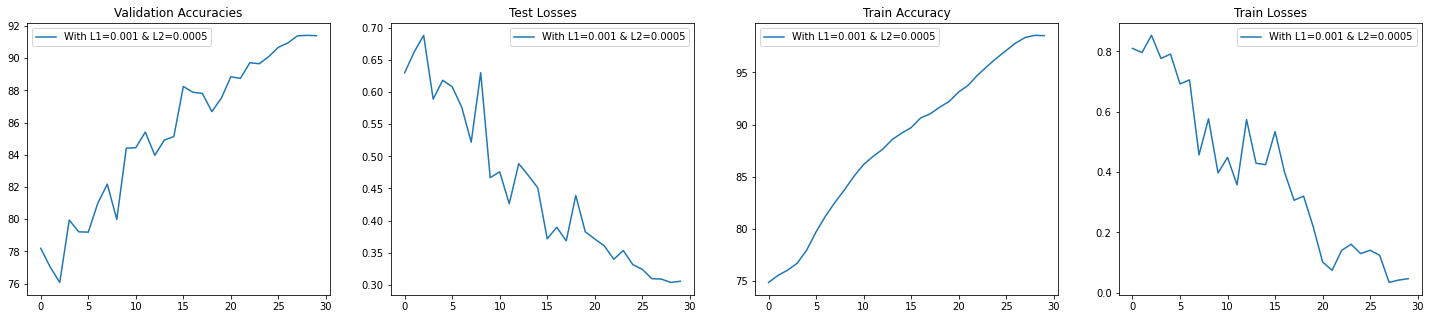

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
    
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.001 & L2=0.0005']

plt.subplot(1,4,1)
plt.title("Validation Accuracies")
plt.plot(test_acc_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,2)
plt.title("Test Losses")
plt.plot(test_loss_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,3)
plt.title("Train Accuracy")
plt.plot(train_acc_all,label=labels[0])
plt.legend(loc="best")   

plt.subplot(1,4,4)
plt.title("Train Losses")
plt.plot(train_loss_all,label=labels[0])
plt.legend(loc="best")    

In [42]:
! ls

data  models  README.md  S9_GradCam_Images  S9_GradCam_Images.zip


In [43]:
import zipfile
from zipfile import ZipFile 
file_name = "S9_GradCam_Images.zip"
with ZipFile(file_name, 'r') as zip: 
     zip.printdir()
     zip.extractall() 

File Name                                             Modified             Size
S9_GradCam_Images/                             2020-03-21 20:50:24            0
S9_GradCam_Images/Bird_1.jpg                   2020-03-21 17:40:44       136259
S9_GradCam_Images/Car_1.jpg                    2020-03-21 17:39:56       232076
S9_GradCam_Images/Cat_1.jpg                    2019-12-05 21:42:24        28789
S9_GradCam_Images/Deer_1.jpg                   2020-03-21 17:44:44       232142
S9_GradCam_Images/Dog_1.jpg                    2020-03-21 17:43:24       482834
S9_GradCam_Images/Frog_1.jpg                   2020-03-21 17:42:40       308961
S9_GradCam_Images/Horse_1.jpg                  2020-03-21 17:42:50       243834
S9_GradCam_Images/Plane_1.jpg                  2020-03-21 17:38:26       444681
S9_GradCam_Images/Plane_2.jpg                  2020-03-21 20:50:24       103991
S9_GradCam_Images/Ship_1.jpg                   2020-03-21 17:43:00       232440
S9_GradCam_Images/Truck_1.jpg           

In [44]:
for img in os.listdir('S9_GradCam_Images/'):  
    img_name = os.path.join('S9_GradCam_Images/',img)  # convert to array
    print(img_name)

S9_GradCam_Images/Bird_2.jpg
S9_GradCam_Images/Cat_2.jpg
S9_GradCam_Images/Car_2.jpg
S9_GradCam_Images/Dog_1.jpg
S9_GradCam_Images/Frog_1.jpg
S9_GradCam_Images/Deer_1.jpg
S9_GradCam_Images/Car_1.jpg
S9_GradCam_Images/Dog_2.jpg
S9_GradCam_Images/Cat_1.jpg
S9_GradCam_Images/Bird_1.jpg
S9_GradCam_Images/Ship_1.jpg
S9_GradCam_Images/Horse_2.jpg
S9_GradCam_Images/Truck_1.jpg
S9_GradCam_Images/Ship_2.jpg
S9_GradCam_Images/Plane_2.jpg
S9_GradCam_Images/Plane_1.jpg
S9_GradCam_Images/Horse_1.jpg


##Gradcam



In [0]:
import cv2
import urllib
import numpy as np
from google.colab.patches import cv2_imshow

def getimage(img, transform, input_size=(32,32)):
    img = cv2.imread(img, 1)
    img = img[:,:, -1::-1]
    img = np.uint8(cv2.resize(img, input_size))
    return transform(img)

In [0]:
gradcam_images = [(0, 'S9_GradCam_Images/Plane_2.jpg'),
                  (1, 'S9_GradCam_Images/Car_2.jpg'),
                  (2, 'S9_GradCam_Images/Bird_2.jpg'),
                  (3, 'S9_GradCam_Images/Cat_2.jpg'),
                  (4, 'S9_GradCam_Images/Deer_1.jpg'),
                  (5, 'S9_GradCam_Images/Dog_2.jpg'),
                  (6, 'S9_GradCam_Images/Frog_1.jpg'),
                  (7, 'S9_GradCam_Images/Horse_2.jpg'),
                  (8, 'S9_GradCam_Images/Ship_2.jpg'),
                  (9, 'S9_GradCam_Images/Truck_1.jpg')]

images = []
target_classes = []

for i in gradcam_images:
  images.append(getimage(i[1], test_transforms))
  target_classes.append(i[0])

In [47]:
target_classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


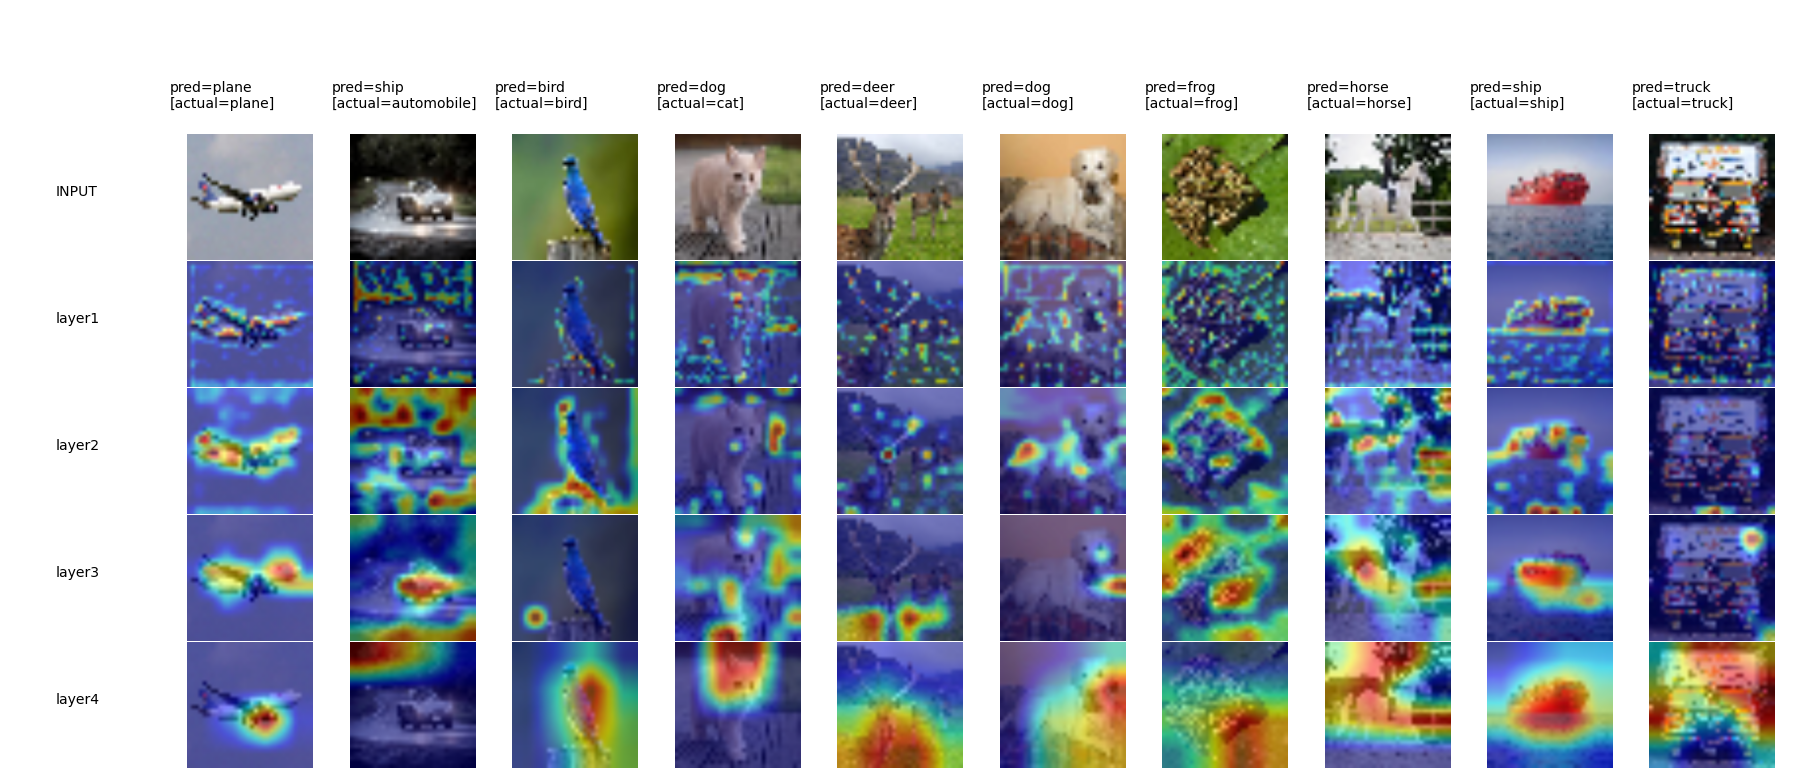

In [48]:
target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = Gradcam.GRADCAM(images, target_classes, model, target_layers)
Gradcam.PLOT(gradcam_output, images, target_classes, target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)